<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models

## Notebook Setup

Run this cell every time the notebook is opened to mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If any import statements cannot be resolved, run this cell to re-install those packages.

In [ ]:
%pip install scanpy
%pip install anndata
%pip install igraph
%pip install pydeseq2
%pip install decoupler
%pip install gseapy==1.1.6

Import statements

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import random
import gc
import decoupler as dc
from scipy.stats import median_abs_deviation
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
#import gseapy as gp

## Read in Kim et al scRNA-seq 10X output files and save as .h5ad.gz files (perform once)

**Read in the scRNA-seq data for Kim et al dataset day 53 untreated sample and day 53 acute fentanyl treatment sample, add metadata and prepend cell barcodes with unique identifiers, and save each sample as a separate `.h5ad.gz` file. Then merge the datasets and save the merged dataset as a `h5ad.gz` file as well.**

The original sample IDs are KH001 for the day 53 untreated sample and KH002 for the day 53 acute fentanyl treatment sample. Each sample has its own folder containing 3 compressed (`.gz`) files, which are the 10X Genomics CellRanger output files:

*   `matrix.mtx.gz` is a count matrix where rows are single cells, columns are genes, and each cell is the read count of that gene in that cell
*   `barcodes.tsv.gz` contains the cell barcodes (each cell is labeled with a unique barcode, which is used as an identifier)
*   `features.tsv.gz` contains the gene names

For each of the 2 samples, we will first use `scanpy.read_10x_mtx()` to read the 3 files into a single `AnnData` object that contains the cell-by-gene matrix and associated metadata (`obs` = barcodes, `var` = features). We will add columns to the `obs` attribute, `Sample` indicating the sample name and `condition` indicating the treatment group of the sample (untreated or fentanyl). In preparation for merging these samples into one `AnnData` object later, we will prepend the cell barcodes with a sample description, "d53_ut" for untreated samples and "d53_fty" for treated samples. Then we will save each sample `AnnData` object as a compressed `.h5ad.gz` file for later use.

In [ ]:
# sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH001_Day53_Untreated"
# adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
# adata1.obs["Sample"] = "kim_day53_untreated"
# adata1.obs["condition"] = "untreated"
# adata1.obs.index = [f"d53_ut_{barcode}" for barcode in adata1.obs.index]
# adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ut.h5ad.gz", compression="gzip")

# sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH002_Day53_FTY_Acute"
# adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
# adata2.obs["Sample"] = "kim_d53_fty_acute"
# adata2.obs["condition"] = "untreated"
# adata2.obs.index = [f"d53_fty_{barcode}" for barcode in adata2.obs.index]
# adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_fty.h5ad.gz", compression="gzip")

Now we will merge the two samples into one `AnnData` object and save the merged dataset as a `.h5ad.gz` file as well.

In [ ]:
# adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample1", "sample2"])
# adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

## QC on Kim et al scRNA-seq dataset

We will read in the Kim et al combined dataset as an `AnnData` object using `scanpy.read_h5ad()`.

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz")

Before QC and preprocessing, we will create a `counts` layer in the `AnnData` object to store the raw counts.

In [ ]:
kim_d53.layers["counts"] = kim_d53.X.copy()

We will begin QC by calculating common QC metrics with `scanpy.pp.calculate_qc_metrics()`. We will also label mitochondrial, ribosomal, and hemoglobin genes.

In [ ]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
kim_d53.var["mt"] = kim_d53.var_names.str.startswith("MT-")
# ribosomal genes
kim_d53.var["ribo"] = kim_d53.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
kim_d53.var["hb"] = kim_d53.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(kim_d53, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

We will now inspect violin plots for number of genes expressed, total counts per cell, and percentage of counts in mitochondrial genes.

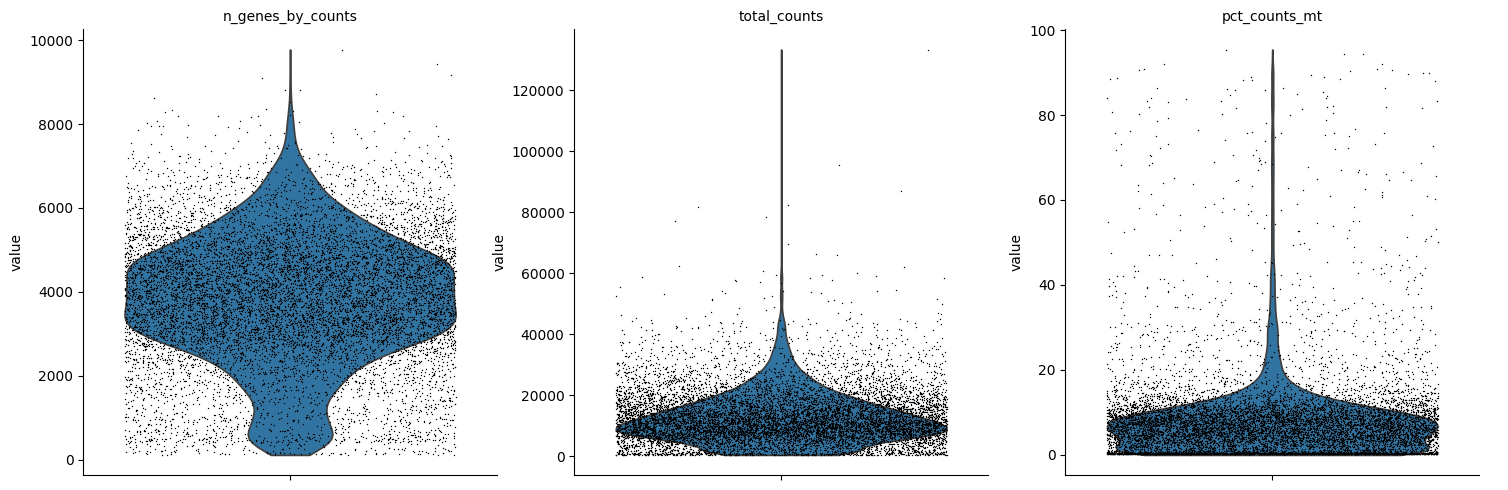

In [ ]:
sc.pl.violin(
    kim_d53,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We can also inspect a joint scatterplot of all 3 metrics.

In [ ]:
sc.pl.scatter(kim_d53, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

To filter out low-quality cells, we will use automatic thresholding via MAD (median absolute deviations) following the [Single-Cell Best Practices](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) tutorial. We will mark cells as outliers if they differ by 3 MADs, as recommended by [Basics of Single-Cell Analysis with Bioconductor](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html). For filtering out cells with a high percentage of mitochondrial genes, we will use 3 MADs. We will also manually set a threshold to filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

kim_d53.obs["outlier"] = (
    is_outlier(kim_d53, "log1p_total_counts", 3)
    | is_outlier(kim_d53, "log1p_n_genes_by_counts", 3)
    | is_outlier(kim_d53, "pct_counts_in_top_20_genes", 3)
    | is_outlier(kim_d53, "pct_counts_mt", 3)
    | (kim_d53.obs["pct_counts_mt"] > 20)
)
kim_d53.obs.outlier.value_counts()

outlier
False    8639
True     1991
Name: count, dtype: int64

Apply the thresholds:

In [ ]:
kim_d53 = kim_d53[~kim_d53.obs.outlier].copy()

We will perform doublet detection so that we can filter out doublets later if desired.

In [ ]:
sc.pp.scrublet(kim_d53, batch_key="Sample")

We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
# kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

Now we will perform differential expression analysis using `PyDESeq2`. First, read in the QC-passed `AnnData` object:

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

## Generating pseudobulk representation of Kim et al scRNA-seq dataset

To generate the pseudobulk dataset, we will cluster by cell type, then for each cell type we will generate pseudoreplicates.

### Preprocessing and clustering with scanpy and decoupler

Read in the QC-passed `AnnData` object:

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

Normalize the data (count depth scaling followed by subsequent log1p transformation):

In [ ]:
sc.pp.normalize_total(kim_d53)
sc.pp.log1p(kim_d53)
kim_d53.layers['log_norm'] = kim_d53.X.copy()

Identify highly variable genes (feature selection), which we will use for further analysis:

In [ ]:
sc.pp.highly_variable_genes(kim_d53, n_top_genes=2000)

Regress out mitochondrial genes and scale the data:

In [ ]:
sc.pp.regress_out(kim_d53, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(kim_d53, max_value=10)

Generate PCA features

In [ ]:
sc.tl.pca(kim_d53, use_highly_variable=True)

In [ ]:
sc.pl.pca_variance_ratio(kim_d53, n_pcs=50, log=True)

Restore `kim_d53.X` to normalized counts

In [ ]:
#dc.swap_layer(kim_d53, 'log_norm', X_layer_key=None, inplace=True)

Compute distances in the PCA space, and find cell neighbors:

In [ ]:
sc.pp.neighbors(kim_d53, n_pcs=40)

Generate UMAP features

In [ ]:
sc.tl.umap(kim_d53)

Perform Leiden clustering

In [ ]:
sc.tl.leiden(kim_d53, flavor='igraph', n_iterations=2, directed=False)

Visualize UMAP

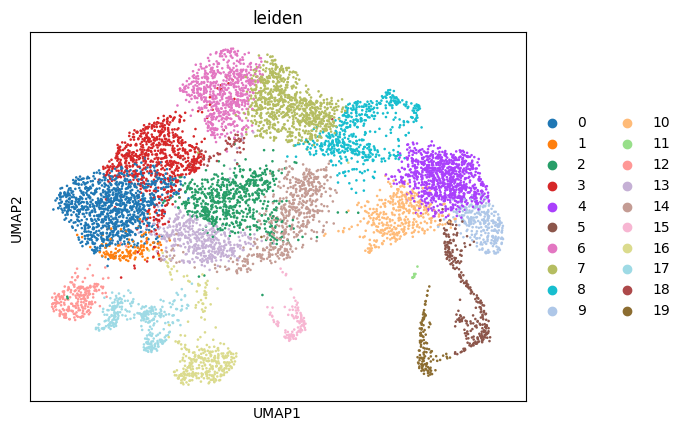

In [ ]:
sc.pl.umap(kim_d53, color='leiden')

### Cell type annotation

We want to recapitulate the cell type clustering performed by Kim et al, where they found the following cell types:
-  DA (dopaminergic neurons)
-  Endo (endothelial cells)
-  Gaba (GABAergic neurons)
-  Mgl (microglia)
-  Nb (neuroblasts?)
-  NProg (neuronal progenitor)
-  OMTN (oculomotor and trochlear nucleus)
-  Peric (pericytes)
-  Prog (progenitor)
-  Rgl (radial glia-like cells)
-  RN (red nucleus neurons)
-  Sert (serotonergic neurons)

PanglaoDB has gene markers for DA, Endo, Gaba, Mgl, Nb, Peric, Rgl, and Sert, but not for NProg, OMTN, Prog, and RN.

Kim et al performed cell type annotation by co-clustering the data with an annotated human fetal midbrain reference dataset from La Manno et al (2016). We will use the gene markers published by La Manno et al in their spreadsheet of "Binarized genes across cell types." Our version of the spreadsheet was edited to reflect the cell types used by Kim et al (e.g. combining all cell types with 'Prog' in the name). Read in the spreadsheet:

In [ ]:
gene_markers = pd.read_excel("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/La Manno 2016 marker genes.xlsx", header=1, index_col=0)

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
gene_markers.head()

Basal  Endo  Peric  Mgl  OPC  Rgl  Prog  NProg  Nb  RN  DA  Gaba  \
A1BG          0     0      0    0    0    0     0      0   0   0   0     0   
A1BG-AS1      0     0      0    0    0    0     0      0   0   0   0     0   
A1CF          0     0      0    0    0    0     0      0   0   0   0     0   
A2M           0     1      1    1    0    0     0      0   0   0   0     0   
A2M-AS1       0     0      0    0    0    0     0      0   0   0   0     1   

          Sert  OMTN  
A1BG         0     0  
A1BG-AS1     0     0  
A1CF         0     0  
A2M          0     0  
A2M-AS1      0     0

We will only consider marker genes that are expressed in a single cell type. Save these genes in a dict:

In [ ]:
gene_marker_dict = dict()
gene_markers = gene_markers[gene_markers.sum(axis=1) == 1]
for col in gene_markers.columns:
  gene_marker_dict[col] = gene_markers[gene_markers[col] != 0].index.tolist()
for key in gene_marker_dict:
  print(f"{key}: {gene_marker_dict[key]}")

Basal: ['ACTB', 'ACTG1', 'ATF4', 'ATP5B', 'ATP5E', 'ATP5F1', 'ATP5I', 'ATP5L', 'ATP5O', 'BRK1', 'BZW1', 'C14orf2', 'C7orf55-LUC7L2', 'CFL1', 'CHCHD2', 'COX4I1', 'COX6B1', 'COX6C', 'DDX5', 'DYNLL1', 'EEF1A1', 'EEF1G', 'EEF2', 'EIF4A2', 'FAU', 'GABARAP', 'H3F3B', 'HNRNPA2B1', 'HNRNPDL', 'HNRNPK', 'HNRNPU', 'HSP90AB1', 'HSPA8', 'MARCKS', 'NACA2', 'NDUFA13', 'NGFRAP1', 'PARK7', 'PCBP1', 'PFDN5', 'PSMB4', 'RBM39', 'RBM8A', 'RPL10', 'RPL13', 'RPL14', 'RPL15', 'RPL28', 'RPL3', 'RPL31', 'RPL34', 'RPL38', 'RPL41', 'RPL6', 'RPL7', 'RPL7A', 'RPL8', 'RPL9', 'RPLP0', 'RPS17_loc1', 'RPS27A', 'RPS4X', 'RPS8', 'RSRC2', 'SAP18', 'SEC61B', 'SEC61G', 'SERBP1', 'SF3B1', 'SKP1', 'SLC25A3', 'SON', 'SRP14', 'SRSF5', 'SUB1', 'SUMO2', 'TCEB2', 'TSC22D1', 'TUBA1B', 'UBB', 'UBL5', 'UQCRB', 'UQCRQ']
Endo: ['ABCB1', 'ABCB4', 'ABCG2', 'ACE', 'ACTN4', 'ACVRL1', 'ADAM10', 'ADAM15', 'ADAMTSL2', 'ADM', 'ADM5', 'ADORA2A', 'AFAP1L1', 'ALPL', 'ANXA2R', 'ANXA3', 'APLN', 'APLNR', 'APRT', 'ARHGAP18', 'ARHGEF15', 'ATP10A', 'B

Save the dict as a `.txt` file:

In [ ]:
with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_gene_markers.txt", "w") as f:
  for k in gene_marker_dict:
    f.write(f"{k}: {gene_marker_dict[k]}\n")

Read in marker gene `.txt` file and convert to Python dict:

In [ ]:
with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_gene_markers.txt") as f:
  gene_txt = f.read()

In [ ]:
all_marker_genes = dict()
for entry in gene_txt.split("\n")[:-1]:
  entry = entry.split(":")
  cell_type = entry[0].strip()
  genes_str = entry[1].strip()
  genes_str = genes_str[2:-2]
  genes = genes_str.split("', '")
  all_marker_genes[cell_type] = genes

Subset to only the marker genes and cell types in the dataset:

In [ ]:
marker_genes = dict()
cell_types = list(all_marker_genes.keys())
cell_types.remove('Basal')
for cell in cell_types:
  marker_genes[cell] = [gene for gene in all_marker_genes[cell] if gene in kim_d53.var.index]
for key in marker_genes:
  print(f"{key}: {marker_genes[key]}")
  for gene in marker_genes[key]:
    if gene not in kim_d53.var.index:
      print(f"{gene} not in dataset")

Endo: ['ABCB1', 'ABCB4', 'ABCG2', 'ACE', 'ACTN4', 'ACVRL1', 'ADAM10', 'ADAM15', 'ADAMTSL2', 'ADM', 'ADM5', 'ADORA2A', 'AFAP1L1', 'ALPL', 'ANXA2R', 'ANXA3', 'APLN', 'APLNR', 'APRT', 'ARHGAP18', 'ARHGEF15', 'ATP10A', 'BCAM', 'BCL6B', 'BHLHE40', 'BNIP2', 'BOK', 'BSG', 'BTNL9', 'C1orf115', 'C1orf54', 'C2CD4B', 'CA5A', 'CARD10', 'CARD8', 'CASP10', 'CASP3', 'CAV1', 'CCDC68', 'CCNL1', 'CCNY', 'CD27', 'CD320', 'CD34', 'CD55', 'CD59', 'CD93', 'CDA', 'CDH5', 'CDKN2B', 'CEACAM21', 'CERS2', 'CFLAR', 'CGNL1', 'CHST15', 'CHST7', 'CKMT2', 'CLDN5', 'CLEC14A', 'CLEC1A', 'CLEC2B', 'CLEC3B', 'CLIC2', 'CLIC4', 'CLIC5', 'CPD', 'CSF3', 'CSRP1', 'CXCL1', 'CXCL12', 'CXorf36', 'CYB5A', 'DAP', 'DDX58', 'DEDD2', 'DEGS2', 'DENND2C', 'DLL4', 'DNASE1L3', 'DOCK9', 'DPEP1', 'DTX3L', 'DUSP6', 'DYSF', 'ECM1', 'ECSCR', 'EDN1', 'EDN3', 'EFNA1', 'EFNB2', 'EGFL7', 'ENG', 'EOGT', 'EPHX4', 'ERG', 'ERVMER34-1', 'ESAM', 'ESM1', 'ESYT2', 'F2RL1', 'FAM124B', 'FAM213A', 'FAM43A', 'FAM78A', 'FCHO2', 'FGR', 'FLNB', 'FLT1', 'FLT4', 

Visualize the UMAP again:

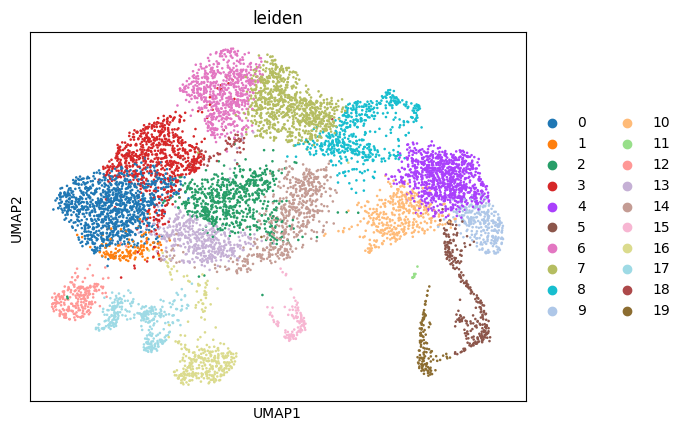

In [ ]:
sc.pl.umap(kim_d53, color='leiden')

Generate UMAPs at a resolution that creates 12 clusters for 12 cell types

In [ ]:
sc.tl.leiden(kim_d53, key_added=f"leiden_res_0.60", resolution=0.60, flavor="igraph")

Visualize the UMAP

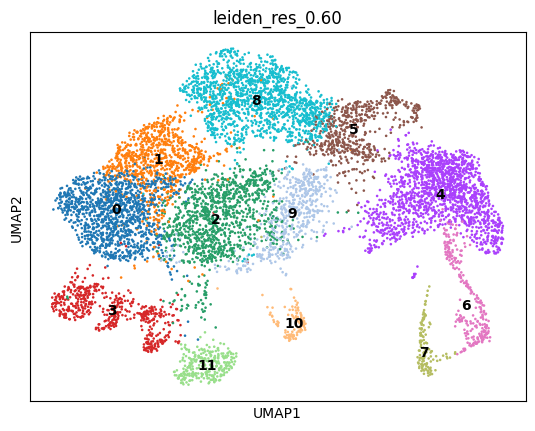

In [ ]:
sc.pl.umap(kim_d53, color="leiden_res_0.60", legend_loc="on data")

Generate dotplot

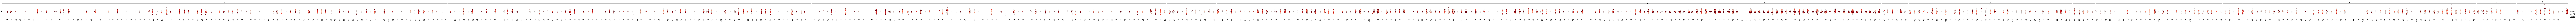

In [ ]:
sc.pl.dotplot(kim_d53, marker_genes, groupby="leiden_res_0.60", standard_scale="var")

## Analysis on Ho et al bulk RNA-seq data

### DEA on Ho et al data

First, we read in Ho et al bulk RNA-seq data, which is in the form of a gene-by-sample matrix within a .txt file. We then transpose this matrix into a sample-by-gene matrix, from which we then remove genes that are not expressed in at least 10 cells.

In [ ]:
counts_raw = pd.read_table("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE210206_counts.txt", index_col=0, header=0)
#Transposing data:
counts_df = counts_raw.T
print(f"Number of genes before filtering: {counts_df.shape[1]}")
#Filtering data:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
print(f"Number of genes after filtering: {counts_df.shape[1]}")
counts_df.head()

NameError: name 'pd' is not defined

We will save the transposed and filtered `DataFrame` as a `.csv` file.

In [ ]:
#counts_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv")

Now, we read in our sample metadata:

In [ ]:
metadata_Ho = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
metadata_Ho.head()

Condition
Sample                  
OFO1003B1  buprenorphine
OFO1003B2  buprenorphine
OFO1003O1      oxycodone
OFO1003O2      oxycodone
OFO1003V1            PBS

Now, we create our `DeseqDataSet` object and then fit said object with dispersions and LFCs for differential expression analysis.

In [ ]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_Ho,
    design="~Condition"
)
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 29.39 seconds.

Fitting dispersion trend curve...
... done in 0.62 seconds.

Fitting MAP dispersions...
... done in 42.08 seconds.

Fitting LFCs...
... done in 17.26 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



Here, we do a quick sanity check of the count data within the above-initialized dds object to ensure the data was normalized upon initialization.

In [ ]:
dds.X

array([[448, 137,  65, ...,   3, 344,   2],
       [437, 121,  82, ...,   1, 363,   0],
       [412, 116,  74, ...,   3, 476,   0],
       ...,
       [222,  68,  53, ...,   0, 849,   1],
       [252,  81,  65, ...,   4, 850,   2],
       [242,  78,  53, ...,   2, 655,   0]])

We will now perform our statistical analyses upon the aforementioned DeseqDataSet by first creating a `DeseqStats` object & then running the `summary()` method.

In [ ]:
ds = DeseqStats(dds, contrast=["Condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...
... done in 5.30 seconds.



Log2 fold change & Wald test p-value: Condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        344.202941       -0.021586  0.327446 -0.065923  0.947439   
LOC729737     102.130186       -0.250510  0.316119 -0.792454  0.428096   
LOC100133331   66.223814        0.089953  0.174544  0.515359  0.606302   
MIR6723        65.966132        0.007637  0.233102  0.032763  0.973864   
LOC100288069   41.854978        0.044645  0.191099  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.020204  0.186730 -0.108199  0.913838   
KDM5D         694.759371       -0.054766  0.081218 -0.674307  0.500116   
TTTY10          3.112367       -0.767770  0.648624 -1.183692  0.236535   
EIF1AY        607.783994        0.298369  0.239899  1.243727  0.213600   
RPS4Y2          0.929605        1.184722  1.365

Here, we perform LFC shrinkage to improve the accuracy of our estimates via shrinking LFC estimates of genes with low information (e.g. low counts or high dispersions) towards 0.

In [ ]:
ds.lfc_shrink(coeff="Condition[T.oxycodone]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Condition[T.oxycodone]
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        344.202941       -0.000782  0.063557 -0.065923  0.947439   
LOC729737     102.130186       -0.010161  0.064603 -0.792454  0.428096   
LOC100133331   66.223814        0.010999  0.061906  0.515359  0.606302   
MIR6723        65.966132        0.000569  0.062428  0.032763  0.973864   
LOC100288069   41.854978        0.004627  0.061568  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.002112  0.061246 -0.108199  0.913838   
KDM5D         694.759371       -0.022112  0.053306 -0.674307  0.500116   
TTTY10          3.112367       -0.007808  0.065157 -1.183692  0.236535   
EIF1AY        607.783994        0.021386  0.067444  1.243727  0.213600   
RPS4Y2          0.929605        0.002804  0.

... done in 49.82 seconds.



Here, we view the results of the above Wald tests.

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False)

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
SLC22A8        17.545470        2.905353  0.904686  4.085724  0.000044   
TMEM72         28.752807        2.665592  0.712462  4.490036  0.000007   
ATP13A5        58.578079        2.493514  0.896273  3.788270  0.000152   
AQP1         1627.090430        2.001534  0.716442  3.786702  0.000153   
CPA4           51.445319        1.997733  0.820159  3.550174  0.000385   
...                  ...             ...       ...       ...       ...   
DACH2          48.335752       -1.207924  0.331860 -4.401986  0.000011   
CYP4X1         45.521659       -1.252895  0.425906 -3.867435  0.000110   
LINC01106       7.020388       -1.475731  0.549401 -3.599393  0.000319   
PWRN1           2.065137       -1.754894  1.290839 -2.810074  0.004953   
SNORD115-45     1.673021       -3.382499  2.563509 -2.132034  0.033004   

                 padj  
gene_symbol            
SLC22A8      0.057740  
TMEM72       0.015206  
ATP13A5      0.097874  
AQP1         0.097874  
CPA4         0.118537  
...               ...  
DACH2        0.020360  
CYP4X1       0.097874  
LINC01106    0.114981  
PWRN1             NaN  
SNORD115-45       NaN  

[20694 rows x 6 columns]

We want to view genes that demonstrate the highest or lowest log2fold changes, but with padj <= 0.05.

---



In [ ]:
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
DEGs_df = ds_df[ds_df["padj"] <= 0.05]
DEGs_df

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                  
TMEM72         28.752807        2.665592  0.712462  4.490036  7.121108e-06   
PTGER2         33.517680        1.533124  0.444303  4.254655  2.093713e-05   
AGPAT9        114.833434        1.239933  0.329331  4.509245  6.505866e-06   
TIMP3        1521.537448        0.874927  0.223534  4.630080  3.655247e-06   
MOSPD1        400.777753        0.627025  0.162526  4.568405  4.914501e-06   
ICT1          336.556565        0.415894  0.099100  4.833475  1.341704e-06   
VKORC1       1213.250268        0.256509  0.045891  6.020707  1.736570e-09   
SRI          1236.440551        0.211202  0.059443  4.161965  3.155211e-05   
MMP3           83.840282       -0.023353  0.071248 -5.239670  1.608637e-07   
RIC3          238.807008       -0.608052  0.157290 -4.575911  4.741512e-06   
DACH2          48.335752       -1.207924  0.331860 -4.401986  1.072646e-05   

                 padj  
gene_symbol            
TMEM72       0.015206  
PTGER2       0.035767  
AGPAT9       0.015206  
TIMP3        0.013992  
MOSPD1       0.013992  
ICT1         0.007640  
VKORC1       0.000030  
SRI          0.049000  
MMP3         0.001374  
RIC3         0.013992  
DACH2        0.020360

Now, we export both our results & the differentially expressed genes as .csv files.

In [ ]:
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
DEGs_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")

### Visualizing Ho et al DEGs

Read in results of statistical analysis

In [ ]:
ds_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
DEGs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")
ds_df.head(10)

gene_symbol     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0       SLC22A8    17.545470        2.905353  0.904686  4.085724  0.000044   
1        TMEM72    28.752807        2.665592  0.712462  4.490036  0.000007   
2       ATP13A5    58.578079        2.493514  0.896273  3.788270  0.000152   
3          AQP1  1627.090430        2.001534  0.716442  3.786702  0.000153   
4          CPA4    51.445319        1.997733  0.820159  3.550174  0.000385   
5            F5   266.068254        1.929397  0.801213  3.533801  0.000410   
6        SPTLC3   129.214930        1.845761  0.698670  3.678189  0.000235   
7  LOC101927023     8.296606        1.834268  0.754869  3.466807  0.000527   
8          SCIN    66.385663        1.820123  0.846961  3.375303  0.000737   
9      ADAMTSL3    45.524064        1.783691  0.811343  3.399214  0.000676   

       padj significance  
0  0.057740           ns  
1  0.015206           up  
2  0.097874           ns  
3  0.097874           ns  
4  0.118537           ns  
5  0.118537           ns  
6  0.106902           ns  
7  0.130395           ns  
8  0.144908           ns  
9  0.142216           ns

We will add a column to the results `DataFrame` indicating whether a gene is non-significant (ns), significant and increases in expression (up), or significant and decreases in expression (down).

In [ ]:
ds_df["significance"] = np.where(ds_df["padj"] > 0.05 | , "ns", np.where(abs(ds_df["log2FoldChange"]) >= 0.25, "up", "down"))

We will save the results DataFrame:


In [ ]:
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")

We now plot the log2 fold-change versus mean expression between both conditions.

In [ ]:
ds.plot_MA(save_path="/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/")


We now generate a volcano plot for the Ho et al DEGs.

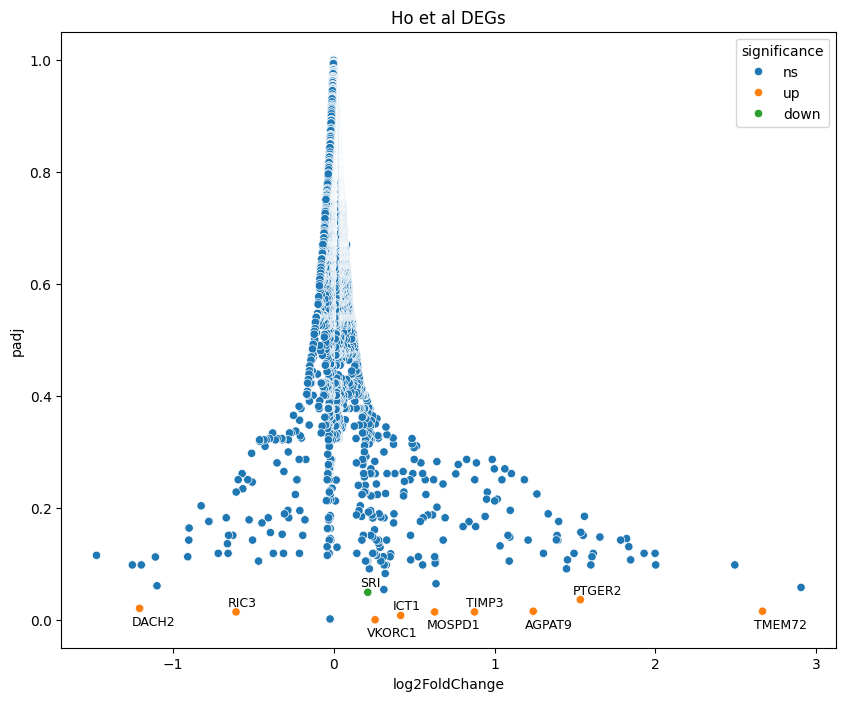

In [ ]:
plt.figure(figsize=(10, 8))
volcano = sns.scatterplot(ds_df, x = 'log2FoldChange', y = 'padj', hue='significance')
volcano.set_title("Ho et al DEGs")
DEGs = ["DACH2", "RIC3", "SRI", "VKORC1", "ICT1", "MOSPD1", "TIMP3", "AGPAT9", "PTGER2", "TMEM72"]
for i, row in DEGs_df.iterrows():
    if row['gene_symbol'] in DEGs:
      if i % 2 == 1:
        volcano.text(row['log2FoldChange']-0.05, row['padj']+0.01, row['gene_symbol'], fontsize=9)
      else:
        volcano.text(row['log2FoldChange']-0.05, row['padj']-0.03, row['gene_symbol'], fontsize=9)

Save the volcano plot:

In [ ]:
volcano.figure.savefig("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_volcano.png", dpi=300)

Now, we generate a heatmap of the changes in normalized exprerssion levels between conditions. To do so, we must first explicitly normalize the counts data via scanpy's scanpy.pp.normalize_total method & saving the results as a dataframe.

In [ ]:
#Pulling out the read counts (saving it as a numpy matrix temporarily):
RawReadsFromDDS = dds.X
#Normalizing the read counts:
NormalizedReads = sc.pp.normalize_total(RawReadsFromDDS)
NormalizedReads

AttributeError: 'numpy.ndarray' object has no attribute 'is_view'

In [ ]:
#Then, we use this new LFC dataframe to initialize a seaborn (denoted sns) heatmap object.
LFC_heatmap = sns.heatmap(LFC_matrix_df, cmap ='autumn', cbar = True)

### ORA on Ho et al data

To perform ORA on the Ho et al data, we ideally want a larger list of DEGs. Previously we performed LFC shrinkage for further visualization and comparison, but this may have narrowed down the DEG list too much. We will repeat the analysis without LFC shrinkage.

In [ ]:
ho_counts = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv", index_col=0)
ho_metadata = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
dds = DeseqDataSet(
    counts=ho_counts,
    metadata=ho_metadata,
    design="~Condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 29.80 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 39.48 seconds.

Fitting LFCs...
... done in 17.08 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



In [ ]:
ds = DeseqStats(dds, contrast=["Condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...
... done in 7.45 seconds.



Log2 fold change & Wald test p-value: Condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P        344.202941       -0.021586  0.327446 -0.065923  0.947439   
LOC729737     102.130186       -0.250510  0.316119 -0.792454  0.428096   
LOC100133331   66.223814        0.089953  0.174544  0.515359  0.606302   
MIR6723        65.966132        0.007637  0.233102  0.032763  0.973864   
LOC100288069   41.854978        0.044645  0.191099  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.020204  0.186730 -0.108199  0.913838   
KDM5D         694.759371       -0.054766  0.081218 -0.674307  0.500116   
TTTY10          3.112367       -0.767770  0.648624 -1.183692  0.236535   
EIF1AY        607.783994        0.298369  0.239899  1.243727  0.213600   
RPS4Y2          0.929605        1.184722  1.365490  0.867617  0.385604   

                  padj  
WASH7P        0.99052

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
ho_degs = ds_df[ds_df["padj"] <= 0.05]
ho_degs

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TMEM72    28.752807        2.997913  0.667681  4.490036  7.121108e-06   
PTGER2    33.517680        1.752511  0.411904  4.254655  2.093713e-05   
AGPAT9   114.833434        1.391940  0.308686  4.509245  6.505866e-06   
TIMP3   1521.537448        0.974865  0.210550  4.630080  3.655247e-06   
MOSPD1   400.777753        0.699858  0.153195  4.568405  4.914501e-06   
ICT1     336.556565        0.456857  0.094519  4.833475  1.341704e-06   
VKORC1  1213.250268        0.270438  0.044918  6.020707  1.736570e-09   
SRI     1236.440551        0.236830  0.056903  4.161965  3.155211e-05   
RIC3     238.807008       -0.678952  0.148375 -4.575911  4.741512e-06   
DACH2     48.335752       -1.366387  0.310402 -4.401986  1.072646e-05   
MMP3      83.840282       -3.709733  0.708009 -5.239670  1.608637e-07   

            padj  
TMEM72  0.015206  
PTGER2  0.035767  
AGPAT9  0.015206  
TIMP3   0.013992  
MOSPD1  0.013992  
ICT1    0.007640  
VKORC1  0.000030  
SRI     0.049000  
RIC3    0.013992  
DACH2   0.020360  
MMP3    0.001374

The DEGs from the DEA performed without LFC shrinkage are the same, so we will proceed with ORA.

In [ ]:
# Read in DEGs
ho_degs = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")
# Get lists of upregulated and downregulated genes
ho_degs_up = ho_degs[ho_degs['log2FoldChange'] > 0]
ho_degs_up = ho_degs_up['gene_symbol'].tolist()
ho_degs_down = ho_degs[ho_degs['log2FoldChange'] < 0]
ho_degs_down = ho_degs_down['gene_symbol'].tolist()

We will start with ORA compared to the GO database:

In [ ]:
# Upregulated genes
ho_ora_up_go = gp.enrichr(
    gene_list=ho_degs_up,
    gene_sets=["GO_Biological_Process_2023"],
    organism="human",
    outdir=None
)
# Downregulated genes
ho_ora_down_go = gp.enrichr(
    gene_list=ho_degs_down,
    gene_sets=["GO_Biological_Process_2023"],
    organism="human",
    outdir=None
)
ho_ora_up_go_df = ho_ora_up_go.results
ho_ora_down_go_df = ho_ora_down_go.results

In [ ]:
ho_ora_up_go_df_p = ho_ora_up_go_df[ho_ora_up_go_df['Adjusted P-value'] < 0.05]
ho_ora_up_go_df_p.loc[:, 'Adjusted P-value'] = ho_ora_up_go_df_p['Adjusted P-value'].round(4)
ho_ora_up_go_df_p.loc[:, 'Combined Score'] = ho_ora_up_go_df_p['Combined Score'].round()
ho_ora_up_go_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

Term  Adjusted P-value  \
0   Positive Regulation Of Extrinsic Apoptotic Sig...            0.0160   
2   Intracellular Sequestering Of Iron Ion (GO:000...            0.0160   
3      Negative Regulation Of Heart Rate (GO:0010459)            0.0160   
4     Regulation Of Relaxation Of Muscle (GO:1901077)            0.0160   
5   Cellular Response To Prostaglandin E Stimulus ...            0.0160   
1   Negative Regulation Of Membrane Protein Ectodo...            0.0160   
6            Vitamin K Metabolic Process (GO:0042373)            0.0160   
7   Regulation Of High Voltage-Gated Calcium Chann...            0.0160   
8   Cellular Response To Prostaglandin Stimulus (G...            0.0160   
9              Quinone Metabolic Process (GO:1901661)            0.0160   
10  Regulation Of Actin Filament-Based Movement (G...            0.0160   
11           Response To Prostaglandin E (GO:0034695)            0.0160   
15  Negative Regulation Of Heart Contraction (GO:0...            0.0160   
16  Regulation Of Cell Communication By Electrical...            0.0160   
12   Regulation Of Muscle System Process (GO:0090257)            0.0160   
14  Negative Regulation Of Ryanodine-Sensitive Cal...            0.0160   
13  Negative Regulation Of Release Of Sequestered ...            0.0160   
17  Regulation Of Cell Communication By Electrical...            0.0165   
18  Regulation Of Membrane Protein Ectodomain Prot...            0.0255   
19   Peptidyl-Glutamic Acid Modification (GO:0018200)            0.0255   
20  Regulation Of Release Of Sequestered Calcium I...            0.0255   
21  Fat-Soluble Vitamin Metabolic Process (GO:0006...            0.0255   
22  Regulation Of Ryanodine-Sensitive Calcium-Rele...            0.0255   
23  Regulation Of Cardiac Muscle Cell Contraction ...            0.0255   
24  Negative Regulation Of Cation Channel Activity...            0.0255   
25  Regulation Of Voltage-Gated Calcium Channel Ac...            0.0255   
26      Regulation Of Muscle Contraction (GO:0006937)            0.0255   
27  Regulation Of Striated Muscle Contraction (GO:...            0.0255   
28  Negative Regulation Of Calcium Ion Transmembra...            0.0255   
29       Regulation Of Blood Circulation (GO:1903522)            0.0261   
30     Regulation Of Metal Ion Transport (GO:0010959)            0.0261   
31                      Action Potential (GO:0001508)            0.0261   
32  Regulation Of Cardiac Muscle Contraction (GO:0...            0.0261   
33    Negative Regulation Of Proteolysis (GO:0045861)            0.0297   
34           Cellular Response To Ketone (GO:1901655)            0.0301   
35                      Bone Development (GO:0060348)            0.0301   
36  Negative Regulation Of ERK1 And ERK2 Cascade (...            0.0317   
37      Regulation Of Cell Communication (GO:0010646)            0.0317   
38  Regulation Of Release Of Sequestered Calcium I...            0.0321   
39          Cellular Response To Alcohol (GO:0097306)            0.0324   
40  Negative Regulation Of Protein Catabolic Proce...            0.0324   
41   Regulation Of Calcium Ion Transport (GO:0051924)            0.0331   
42              Muscle Organ Development (GO:0007517)            0.0331   
43  Negative Regulation Of Peptidase Activity (GO:...            0.0335   
44  Negative Regulation Of Endopeptidase Activity ...            0.0352   
45  Negative Regulation Of Cellular Catabolic Proc...            0.0352   
46       Regulation Of Heart Contraction (GO:0008016)            0.0352   
47  Regulation Of Endopeptidase Activity (GO:0052548)            0.0352   

    Combined Score Overlap   Genes  
0           4437.0     1/5   TIMP3  
2           3445.0     1/6     SRI  
3           3445.0     1/6     SRI  
4           3445.0     1/6     SRI  
5           3445.0     1/6  PTGER2  
1           3445.0     1/6   TIMP3  
6           2343.0     1/8  VKORC1  
7           2008.0     1/9     SRI  
8           2008.0     1/9  PTGER2  
9  

In [ ]:
ho_ora_down_go_df_p = ho_ora_down_go_df[ho_ora_down_go_df['Adjusted P-value'] < 0.05]
ho_ora_down_go_df_p.loc[:, 'Adjusted P-value'] = ho_ora_down_go_df_p['Adjusted P-value'].round(4)
ho_ora_down_go_df_p.loc[:, 'Combined Score'] = ho_ora_down_go_df_p['Combined Score'].round()
ho_ora_down_go_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

Term  Adjusted P-value  \
0   Regulation Of Hydrogen Peroxide Metabolic Proc...            0.0080   
1      Cellular Response To Nitric Oxide (GO:0071732)            0.0080   
2   Regulation Of Oxidative Stress-Induced Cell De...            0.0080   
3   Cellular Response To Reactive Nitrogen Species...            0.0080   
4              Cellular Response To UV-A (GO:0071492)            0.0080   
5               Response To Nitric Oxide (GO:0071731)            0.0080   
6   Positive Regulation Of Protein Localization To...            0.0080   
7                       Response To UV-A (GO:0070141)            0.0080   
8     Synaptic Transmission, Cholinergic (GO:0007271)            0.0085   
9   Cellular Response To Inorganic Substance (GO:0...            0.0085   
10  Regulation Of Neuroinflammatory Response (GO:0...            0.0085   
11  Negative Regulation Of Reactive Oxygen Species...            0.0087   
12  Protein Localization To Cell Surface (GO:0034394)            0.0099   
13  Regulation Of Protein Localization To Cell Sur...            0.0109   
14                   Response To Peptide (GO:1901652)            0.0125   
15              Response To Amyloid-Beta (GO:1904645)            0.0126   
16      Extracellular Matrix Disassembly (GO:0022617)            0.0126   
17        Cellular Component Disassembly (GO:0022411)            0.0126   
18     Positive Regulation Of Cell Death (GO:0010942)            0.0130   
19               Cellular Response To UV (GO:0034644)            0.0195   
20  Positive Regulation Of Protein Localization (G...            0.0200   
21  Positive Regulation Of Cellular Component Biog...            0.0208   
22  Positive Regulation Of Protein-Containing Comp...            0.0210   
23  Extracellular Structure Organization (GO:0043062)            0.0214   
24  External Encapsulating Structure Organization ...            0.0214   
25  Positive Regulation Of Cellular Component Orga...            0.0214   
26  Regulation Of Protein-Containing Complex Assem...            0.0217   
27     Extracellular Matrix Organization (GO:0030198)            0.0308   
28   Regulation Of Inflammatory Response (GO:0050727)            0.0405   
29        Chemical Synaptic Transmission (GO:0007268)            0.0444   

    Combined Score Overlap Genes  
0          17983.0     1/5  MMP3  
1          11427.0     1/7  MMP3  
2          11427.0     1/7  MMP3  
3          11427.0     1/7  MMP3  
4           7221.0    1/10  MMP3  
5           6403.0    1/11  MMP3  
6           5742.0    1/12  RIC3  
7           5197.0    1/13  MMP3  
8           4018.0    1/16  RIC3  
9           3476.0    1/18  MMP3  
10          3253.0    1/19  MMP3  
11          2877.0    1/21  MMP3  
12          2216.0    1/26  RIC3  
13          1788.0    1/31  RIC3  
14          1394.0    1/38  MMP3  
15          1199.0    1/43  MMP3  
16          1165.0    1/44  MMP3  
17          1104.0    1/46  MMP3  
18           996.0    1/50  MMP3  
19           567.0    1/79  MMP3  
20           518.0    1/85  RIC3  
21           463.0    1/93  MMP3  
22           433.0    1/98  MMP3  
23           379.0   1/109  MMP3  
24           375.0   1/110  MMP3  
25           362.0   1/113  MMP3  
26           340.0   1/119  MMP3  
27           206.0   1/176  MMP3  
28           138.0   1/240  MMP3  
29           116.0   1/273  RIC3

Next, we will perform ORA with MSigDB:

In [ ]:
# Upregulated genes
ho_ora_up_msig = gp.enrichr(
    gene_list=ho_degs_up,
    gene_sets="MSigDB_Hallmark_2020",
    organism="human",
    outdir=None
)
# Downregulated genes
ho_ora_down_msig = gp.enrichr(
    gene_list=ho_degs_down,
    gene_sets="MSigDB_Hallmark_2020",
    organism="human",
    outdir=None
)
ho_ora_up_msig_df = ho_ora_up_msig.results
ho_ora_down_msig_df = ho_ora_down_msig.results

In [ ]:
ho_ora_up_msig_df_p = ho_ora_up_msig_df[ho_ora_up_msig_df['Adjusted P-value'] < 0.05]
ho_ora_up_msig_df_p.loc[:, 'Adjusted P-value'] = ho_ora_up_msig_df_p['Adjusted P-value'].round(4)
ho_ora_up_msig_df_p.loc[:, 'Combined Score'] = ho_ora_up_msig_df_p['Combined Score'].round()
ho_ora_up_msig_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

Term  Adjusted P-value  Combined Score Overlap       Genes
0  Inflammatory Response            0.0214           197.0   2/200  PTGER2;SRI

In [ ]:
ho_ora_down_msig_df_p = ho_ora_down_msig_df[ho_ora_down_msig_df['Adjusted P-value'] < 0.05]
ho_ora_down_msig_df_p.loc[:, 'Adjusted P-value'] = ho_ora_down_msig_df_p['Adjusted P-value'].round(4)
ho_ora_down_msig_df_p.loc[:, 'Combined Score'] = ho_ora_down_msig_df_p['Combined Score'].round()
ho_ora_down_msig_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

Term  Adjusted P-value  Combined Score  \
0                        Coagulation            0.0297           282.0   
1  Epithelial Mesenchymal Transition            0.0297           175.0   

  Overlap Genes  
0   1/138  MMP3  
1   1/200  MMP3

In [ ]:
# Upregulated genes
ho_ora_up_kegg = gp.enrichr(
    gene_list=ho_degs_up,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None
)
# Downregulated genes
ho_ora_down_kegg = gp.enrichr(
    gene_list=ho_degs_down,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None
)
ho_ora_up_kegg_df = ho_ora_up_kegg.results
ho_ora_down_kegg_df = ho_ora_down_kegg.results

In [ ]:
ho_ora_up_kegg_df_p = ho_ora_up_kegg_df[ho_ora_up_kegg_df['Adjusted P-value'] < 0.05]
ho_ora_up_kegg_df_p.loc[:, 'Adjusted P-value'] = ho_ora_up_kegg_df_p['Adjusted P-value'].round(4)
ho_ora_up_kegg_df_p.loc[:, 'Combined Score'] = ho_ora_up_kegg_df_p['Combined Score'].round()
ho_ora_up_kegg_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

Term  Adjusted P-value  \
0  Ubiquinone and other terpenoid-quinone biosynt...            0.0395   

   Combined Score Overlap   Genes  
0          1549.0    1/11  VKORC1

In [ ]:
ho_ora_down_kegg_df_p = ho_ora_down_kegg_df[ho_ora_down_kegg_df['Adjusted P-value'] < 0.05]
ho_ora_down_kegg_df_p.loc[:, 'Adjusted P-value'] = ho_ora_down_kegg_df_p['Adjusted P-value'].round(4)
ho_ora_down_kegg_df_p.loc[:, 'Combined Score'] = ho_ora_down_kegg_df_p['Combined Score'].round()
ho_ora_down_kegg_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

Term  Adjusted P-value  Combined Score  \
0                     Rheumatoid arthritis            0.0292           463.0   
1                  IL-17 signaling pathway            0.0292           457.0   
2                          Prostate cancer            0.0292           439.0   
3                    TNF signaling pathway            0.0292           367.0   
4  Transcriptional misregulation in cancer            0.0344           184.0   
5                Lipid and atherosclerosis            0.0344           159.0   
6                      Coronavirus disease            0.0344           144.0   

  Overlap Genes  
0    1/93  MMP3  
1    1/94  MMP3  
2    1/97  MMP3  
3   1/112  MMP3  
4   1/192  MMP3  
5   1/215  MMP3  
6   1/232  MMP3